In [18]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

def get_camera_calibration_points():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)

    #cv2.destroyAllWindows()
    return (objpoints, imgpoints)

In [19]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


def hsv_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hls[:,:,2]
    binary_output = np.zeros_like(v_channel)
    binary_output[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1
    return binary_output

def grey_select(img, thresh=(0, 255)):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(grey.shape)
    binary_output = np.zeros_like(grey)
    binary_output[(grey > thresh[0]) & (grey <= thresh[1])] = 1
    return binary_output

def color_and_gradient_filter(img, ksize = 15):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 240))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(img, thresh=(100, 255)) #150
    hsv_binary = hsv_select(img, thresh=(50, 255))
    grey_binary = grey_select(img, thresh=(200, 255))
    combined = np.zeros_like(grey_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) & ((hls_binary == 1) | (grey_binary == 1) | (hsv_binary == 1)))] = 1

    combined[((gradx == 1) & (grady == 1)) | (((hls_binary == 1)  & (hsv_binary == 1))) ] = 1
    return combined 

def undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [20]:
def warp(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def unwarp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

class WindowFinder:
    
    def __init__(self, window_width=50, window_height=80, margin=100, meters_pp_y = 1, meters_pp_x= 1, smooth_factor = 15) :
        self.centers = []
        self.window_width = window_width
        self.window_height = window_height
        self.margin = margin
        self.meters_pp_y=meters_pp_y
        self.meters_pp_x=meters_pp_x
        self.smooth_factor=smooth_factor

    def find_window_centroids(self, image):
        window_width = self.window_width
        window_height= self.window_height
        margin= self.margin
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(image.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,image.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        self.centers.append(window_centroids)
        return np.average(self.centers[-self.smooth_factor:], axis=0)


    
def get_window_centers(warped_image):
    window_width=30
    window_height=80
    margin=25
    meters_pp_y = 10/720
    meters_pp_x = 4/380
    curve_centers=WindowFinder(window_width=window_width, window_height=window_height, margin=margin,meters_pp_y=meters_pp_y,meters_pp_x=meters_pp_x )
    window_centroids= curve_centers.find_window_centroids(image=warped_image)

    #points to fit to polinom
    leftx= []
    rightx= []

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas

        #adding center value for drawing
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
    return (leftx, rightx, curve_centers)

In [24]:
def get_final_image(image_input, warped,leftx, rightx, curve_centers, window_height, window_width, src_points, dest_points):
    # fit centers of boxes to polinomial of second degree
    lane_y =range(0, warped.shape[0])
    # box centers
    result_y = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)
    #left line
    left_fit = np.polyfit(result_y, leftx, 2)
    left_fitx = np.array(left_fit[0]*lane_y*lane_y + left_fit[1]*lane_y + left_fit[2], np.int32)
    #right line
    right_fit = np.polyfit(result_y, rightx, 2)
    right_fitx = np.array(right_fit[0]*lane_y*lane_y + right_fit[1]*lane_y + right_fit[2], np.int32)

    #making line thicker so it gets drawn better
    left_line = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)
    right_line = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)

    lanes = np.zeros_like(image_input)
    inbetween_lanes = np.zeros_like(image_input)
    cv2.fillPoly(lanes, [left_line], color=[200,0,0])
    cv2.fillPoly(lanes, [right_line], color=[0,0,200])

    #points = np.concatenate((left_line, right_line))
    points_left = np.array([np.transpose(np.vstack([left_fitx, lane_y]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, lane_y])))])
    points = np.hstack((points_left, points_right))

    cv2.fillPoly(inbetween_lanes, [points], color=(0, 255, 0))
    cv2.fillPoly(inbetween_lanes, [left_line], color=(0, 255, 0))
    cv2.fillPoly(inbetween_lanes, [right_line], color=(0, 255, 0))
    lanes_wraped=unwarp(lanes,src_points, dest_points )
    inbetween_lanes_warped = unwarp(inbetween_lanes,src_points, dest_points )

    image_with_lines = cv2.addWeighted(image_input, 1.0, inbetween_lanes_warped, 0.3, 0.0)
    image_with_lines_road = cv2.addWeighted(image_with_lines, 1.0, lanes_wraped, 1.0, 0.0)
    #calculate curvature radius by formular based on polynomial coefficients, take left turn
    left_fit_x_r= np.array(left_fitx, np.float32)*curve_centers.meters_pp_x
    left_fit_y_r= np.array(lane_y, np.float32)*curve_centers.meters_pp_y
    polynomila_fit_real = np.polyfit(left_fit_y_r, left_fit_x_r, 2)
    left_curverad = ((1 + (2*polynomila_fit_real[0]*lane_y[-1]*curve_centers.meters_pp_y + polynomila_fit_real[1])**2)**1.5) / np.absolute(2*polynomila_fit_real[0])
    font = cv2.FONT_HERSHEY_DUPLEX
    font_color = (255, 255, 255)
    font_scale = 1
    font_thickness = 2
    #Calculating difference from center, assuming tthe middle of the picture should be the center
    meters_to_center= ( (left_fitx[-1] + right_fitx[-1]) /2 - warped.shape[1]/2)*curve_centers.meters_pp_x
    cv2.putText(image_with_lines_road, 'Left radius of curvature: %d m' % (round(left_curverad)), (50,50), font, font_scale, font_color, font_thickness)
    cv2.putText(image_with_lines_road, 'Meters_to_center: %1.2f m' % (meters_to_center), (50,80), font, font_scale, font_color, font_thickness)
    return image_with_lines_road#

In [25]:
(cal_objpoints, cal_imgpoints) = get_camera_calibration_points()


def pipeline(init_image):
    ##constants
    src_points = np.float32([[179, 720], [1140, 720], [740, 460], [550, 460]])
    #src_points = np.float32([[150, 720], [1140, 720], [740, 460], [550, 460]])
    dest_points = np.float32([[350, 720], [977, 720], [977, 0], [350, 0]])
    #trapizoid size
    #bottom_with_pc = 0.76
    #middle_width= 0.8
    #height_pc = 0.62
    #bottom_cut = 0.94
    '''src_points=np.float32([[init_image.shape[1]*(0.5-middle_width/2), init_image.shape[0]*height_pc],
                    [init_image.shape[1]*(0.5+middle_width/2),init_image.shape[0]*height_pc],
                    [init_image.shape[1]*(0.5+bottom_with_pc/2),init_image.shape[1]*bottom_cut],
                     [init_image.shape[1]*(0.5-bottom_with_pc/2),init_image.shape[0]*bottom_cut]     ])
    offset = init_image.shape[1]*0.25
    dest_points = np.float32([[offset, 0], [init_image.shape[1]- offset, 0], \
                              [init_image.shape[1]- offset, init_image.shape[0]],[offset, init_image.shape[0]]])
    '''
    #window_width=25
    #window_height=80
    #margin=25
    #meters_pp_y = 10/720
    #meters_pp_x = 4/380
    
    
    window_width=30
    window_height=80
    margin=25
    meters_pp_y = 10/720
    meters_pp_x = 4/380
    #first undistort 
    undistorted=undistort(init_image, cal_objpoints, cal_imgpoints)  
    masked_image= color_and_gradient_filter(undistorted, ksize = 15)
    warped = warp(masked_image,src_points, dest_points)
    (leftx, rightx, curve_centers) = get_window_centers(warped)
    final_image = get_final_image(init_image, warped, leftx, rightx, curve_centers, window_height,window_width, 
                                  src_points=src_points,dest_points=dest_points  )
    #f = cv2.polylines(final_image,[src_points],True,(0,255,255))
    return final_image

(720, 1280)
./test_images/straight_lines1.jpg


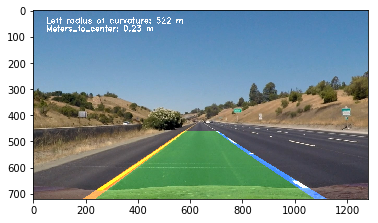

(720, 1280)
./test_images/straight_lines2.jpg


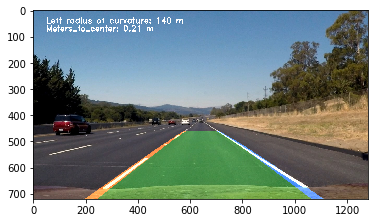

(720, 1280)
./test_images/test1.jpg


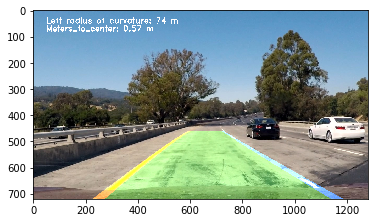

(720, 1280)
./test_images/test2.jpg


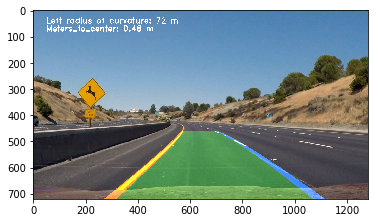

(720, 1280)
./test_images/test3.jpg


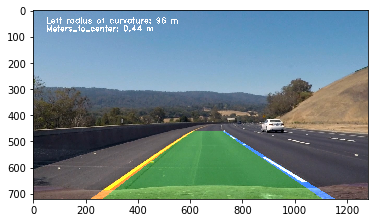

(720, 1280)
./test_images/test4.jpg


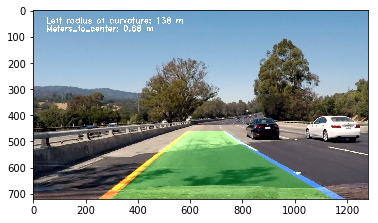

(720, 1280)
./test_images/test5.jpg


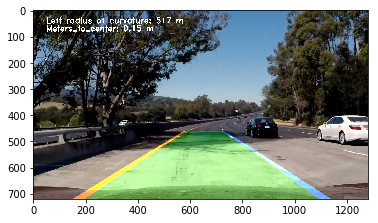

(720, 1280)
./test_images/test6.jpg


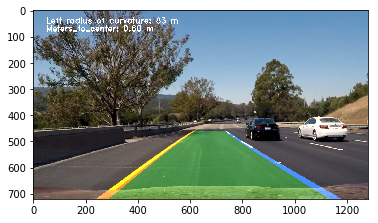

In [26]:
images = glob.glob('./test_images/*.jpg')

    # Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    decorated= pipeline(img)
    print(fname)
    plt.imshow(decorated)
    plt.show()